# Импорт библиотек

In [1]:
import pandas as pd
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SequentialFeatureSelector_mlx
from sklearn.feature_selection import SelectFromModel


# Загрузка и подготовка данных, их обогащение

In [2]:
data = pd.read_excel('data/Сводный отчет за декабрь.xlsx', header=1)

# заменим данные по названиям на числовые
unique_data = data['Название ККТ'].unique()
print(f'Уникальные данные в столбце {"Название ККТ"}: {unique_data}, заменяем числами')
for i in range(len(unique_data)):
    data.replace(unique_data[i],i,inplace=True)

# выберем только данные прихода
data = data[data['Тип операции'] == 'Приход']

# обогащаем данные по времени
data['День'] = data['Дата и время'].apply(lambda x: x.day)
data['День недели'] = data['Дата и время'].apply(lambda x: x.weekday())
data['Выходной'] = data['Дата и время'].apply(lambda x: int(x.weekday() >= 5))

data['Час'] = data['Дата и время'].apply(lambda x: x.hour)

data.head()

Уникальные данные в столбце Название ККТ: ['ТРЦ "Фокус"' 'ТРК "Слон"' 'ТРК "Родник"' nan], заменяем числами


,Дата и время,Тип операции,Наличными,Безналичными,Сумма,Название ККТ,День,День недели,Выходной,Час
0,2023-12-31 18:54:00,Приход,390.0,3.0,390.0,0.0,31,6,1,18
1,2023-12-31 18:53:00,Приход,1490.0,3.0,1490.0,0.0,31,6,1,18
2,2023-12-31 18:46:00,Приход,3.0,2000.0,2000.0,1.0,31,6,1,18
3,2023-12-31 18:45:00,Приход,3.0,590.0,590.0,0.0,31,6,1,18
4,2023-12-31 18:32:00,Приход,3.0,1990.0,1990.0,0.0,31,6,1,18


# Удаляем лишние столбцы, группируем данные по столбцам `'Точка продаж','День','День недели','Выходной','Час'`

In [3]:

data.drop(columns=['Дата и время', 'Тип операции', 'Наличными', 'Безналичными'], inplace=True)
data.rename(columns = {
    'Название ККТ': 'Точка продаж'
}, inplace=True)
df = data.groupby(['Точка продаж','День','День недели','Выходной','Час']).sum().reset_index()

df

,Точка продаж,День,День недели,Выходной,Час,Сумма
0,0.0,1,4,0,21,590.0
1,0.0,2,5,1,11,590.0
2,0.0,2,5,1,14,4260.0
3,0.0,2,5,1,15,1180.0
4,0.0,2,5,1,17,3480.0
...,...,...,...,...,...,...
655,2.0,31,6,1,13,16793.0
656,2.0,31,6,1,14,12190.0
657,2.0,31,6,1,15,4980.0
658,2.0,31,6,1,16,3130.0


In [4]:
df.corr()

,Точка продаж,День,День недели,Выходной,Час,Сумма
Точка продаж,1.000000,0.002089,0.031791,0.027098,-0.005764,0.072312
День,0.002089,1.000000,0.069651,0.021413,-0.008508,0.284334
День недели,0.031791,0.069651,1.000000,0.812530,-0.084829,0.236203
Выходной,0.027098,0.021413,0.812530,1.000000,-0.100291,0.231054
Час,-0.005764,-0.008508,-0.084829,-0.100291,1.000000,-0.028888
Сумма,0.072312,0.284334,0.236203,0.231054,-0.028888,1.000000


# Обозначаем независимые и зависимый столбцы

In [5]:
df.columns
df.rename(columns={
    'Точка продаж': 'xi1',
    'День':         'xi2',
    'День недели':  'xi3',
    'Выходной':     'xi4', 
    'Час':          'xi5',
    'Сумма':        'yi'
}, inplace=True)
df.head()

,xi1,xi2,xi3,xi4,xi5,yi
0,0.0,1,4,0,21,590.0
1,0.0,2,5,1,11,590.0
2,0.0,2,5,1,14,4260.0
3,0.0,2,5,1,15,1180.0
4,0.0,2,5,1,17,3480.0


# Строим модель линейной множественной регрессии

In [6]:
# Определяем зависимую переменную (yi) и независимые переменные (xi1, xi2, xi3, xi4, xi5)
Y = df['yi']
X = df[['xi1', 'xi2', 'xi3', 'xi4', 'xi5']]

# Создаем модель линейной регрессии
model = LinearRegression()

# Обучаем модель
model.fit(X, Y)

# Получаем предсказания модели
predictions = model.predict(X)

# Оцениваем адекватность модели
mse = mean_squared_error(Y, predictions)
r2 = r2_score(Y, predictions)

# Коэффициенты модели
coefficients = model.coef_
intercept = model.intercept_

(mse, r2, coefficients, intercept)

(12930718.80292813,
 0.13907624487309822,
 array([ 303.87152846,  120.31892731,  194.37736475, 1134.15102503,
          -4.32272857]),
 299.1133671704529)

Результаты, которые вы предоставили, представляют собой параметры модели линейной множественной регрессии, построенной на основе ваших данных. Давайте проанализируем их:

1.  **Среднеквадратичная ошибка (MSE)**: Значение MSE равно 12930718. Это показатель ошибки модели, который измеряет среднюю разницу между фактическими значениями и предсказаниями модели. Чем меньше значение MSE, тем лучше модель предсказывает результаты. В вашем случае, MSE относительно высокое, но для полной оценки необходимо сравнить его с диапазоном значений зависимой переменной (yi).
    
2.  **Коэффициент детерминации (R²)**: Значение R² равно 0.14. Этот коэффициент показывает, какая доля изменчивости зависимой переменной объясняется независимыми переменными модели. В данном случае, около 14% вариативности суммы продаж можно объяснить через выбранные факторы. Это незначительная доля.
    
3.  **Коэффициенты модели**: Массив коэффициентов \[303.87152846, 120.31892731, 194.37736475, 1134.15102503, -4.32272857\] соответствует влиянию каждого из факторов xi1, xi2, xi3, xi4, xi5 соответственно.

4.  **Константа (intercept)**: Значение константы 299 представляет собой ожидаемое значение суммы продаж (yi), когда все независимые переменные равны нулю. Она служит начальной точкой для линейного уравнения.

### Выводы:

*   Модель демонстрирует низкую способность объяснять изменения урожайности зерновых культур, так как R² составляет около 14%..
*   Отрицательные коэффициенты у некоторых переменных говорят о том, что увеличение этих факторов может негативно сказаться продажах.

# Вычиление и анализ матрицы корреляций для незасимых переменных

In [7]:

# Вычисляем матрицу корреляций для объясняющих переменных
RXX = X.corr()

# Вычисляем определитель матрицы корреляций
det_RXX = np.linalg.det(RXX)

# Проверяем гипотезу о наличии мультиколлинеарности
# Степени свободы для хи-квадрат распределения
Df = len(X.columns) * (len(X.columns) - 1) / 2

# Вычисляем статистику теста
chi2_stat = -((len(X) - 1) - (2 * len(X.columns) + 5) / 6) * np.log(det_RXX)

# Вычисляем критическое значение для хи-квадрат распределения с уровнем значимости 0.05
chi2_critical = chi2.ppf(0.95, Df)

display(RXX)
(det_RXX, chi2_stat, chi2_critical, chi2_stat > chi2_critical)

,xi1,xi2,xi3,xi4,xi5
xi1,1.000000,0.002089,0.031791,0.027098,-0.005764
xi2,0.002089,1.000000,0.069651,0.021413,-0.008508
xi3,0.031791,0.069651,1.000000,0.812530,-0.084829
xi4,0.027098,0.021413,0.812530,1.000000,-0.100291
xi5,-0.005764,-0.008508,-0.084829,-0.100291,1.000000


(0.33315592971861807, 721.5884569390792, 18.307038053275146, True)

Результаты, которые вы предоставили, включают в себя матрицу выборочных парных коэффициентов корреляции (RXX) между объясняющими переменными, определитель этой матрицы, статистику хи-квадрат, критическое значение хи-квадрат при уровне значимости 0.05, и логическое значение, указывающее на наличие или отсутствие мультиколлинеарности. Давайте проанализируем эти результаты:

### Анализ матрицы корреляций (RXX):

*   Высокие значения корреляции наблюдаются между некоторыми переменными, особенно между xi3 и xi4. Это указывает на сильную линейную зависимость между этими парами переменных.

### Анализ определителя матрицы корреляций:

*   Определитель матрицы RXX равен 0.33, что очень близко к нулю. Это говорит о том, что матрица корреляций почти вырождена, что является признаком мультиколлинеарности (xi3 и xi4).

### Анализ хи-квадрат статистики:

*   Статистика хи-квадрат равна 721, что выше критического значения при уровне значимости 0.05.
*   Так как статистическое значение больше критического, мы принимаем гипотезу о наличии мультиколлинеарности.

### Выводы:

*   На основе представленных данных можно сделать вывод, что в модели присутствует мультиколлинеарность. Это означает, что некоторые объясняющие переменные сильно коррелированы друг с другом, что может привести к проблемам в оценке коэффициентов регрессии и их интерпретации.
*   Для улучшения модели следует рассмотреть возможность исключения одной или нескольких переменных, которые сильно коррелированы с другими, или использовать методы, устойчивые к мультиколлинеарности, такие как гребневая регрессия (ridge regression).

# Анализ значимых незасимых переменных тремя разными методами

,xi1,xi2,xi3,xi4,xi5,yi
xi1,1.000000,0.002089,0.031791,0.027098,-0.005764,0.072312
xi2,0.002089,1.000000,0.069651,0.021413,-0.008508,0.284334
xi3,0.031791,0.069651,1.000000,0.812530,-0.084829,0.236203
xi4,0.027098,0.021413,0.812530,1.000000,-0.100291,0.231054
xi5,-0.005764,-0.008508,-0.084829,-0.100291,1.000000,-0.028888
yi,0.072312,0.284334,0.236203,0.231054,-0.028888,1.000000


Выбранные фичи (Select From Model): ['xi4']
Выбранные фичи (Sequential Feature Selector): ['xi2' 'xi4']
Выбранные фичи (Sequential Feature Selector) mlx model: ('xi1', 'xi2', 'xi4')


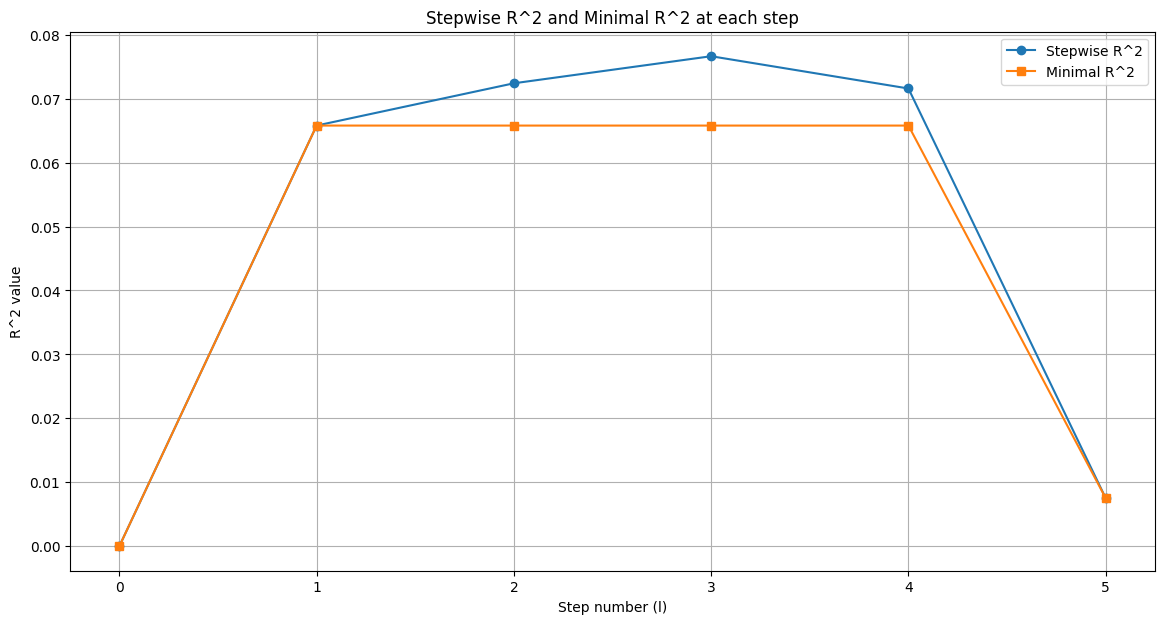

In [8]:
display(df.corr())

# Определяем независимые переменные (X) и зависимую переменную (y)
X = df[['xi1', 'xi2', 'xi3', 'xi4', 'xi5']]
y = df["yi"]

# Настраиваем Select From Model
sfm = SelectFromModel(model, prefit=True).fit(X, y)
X_new = sfm.transform(X)

print(f'Выбранные фичи (Select From Model): {sfm.get_feature_names_out()}')


sfs = SequentialFeatureSelector(LinearRegression(),
          n_features_to_select='auto',
          direction ='forward',
          cv=2).fit(X,y)

print(f'Выбранные фичи (Sequential Feature Selector): {sfs.get_feature_names_out()}')

sfs_mlx = SequentialFeatureSelector_mlx(LinearRegression(),
          k_features='best', forward=False).fit(X,y)
print(f'Выбранные фичи (Sequential Feature Selector) mlx model: {sfs_mlx.k_feature_names_}')



# Получаем результаты
stepwise_r2_results = sfs_mlx.subsets_

# Извлекаем R^2 для каждого шага
r2_per_step = [stepwise_r2_results[i]['avg_score'] for i in stepwise_r2_results.keys()]
r2_min_at_steps = [min(r2_per_step[:i+1]) for i in range(len(r2_per_step))]

# Добавляем начальный шаг, где R^2 равен нулю
r2_per_step = [0] + r2_per_step
r2_min_at_steps = [0] + r2_min_at_steps

# Теперь строим графики R^2 и минимальных значений R^2 на каждом шаге
steps = list(range(len(r2_per_step)))

plt.figure(figsize=(14, 7))

# Строим график R^2 на каждом шаге
plt.plot(steps, r2_per_step, 'o-', label='Stepwise R^2')

# Строим график минимальных значений R^2 на каждом шаге
plt.plot(steps, r2_min_at_steps, 's-', label='Minimal R^2')

# Добавляем метки и заголовок
plt.xlabel('Step number (l)')
plt.ylabel('R^2 value')
plt.title('Stepwise R^2 and Minimal R^2 at each step')
plt.legend()
plt.grid(True)
plt.show()

# выбираем независимые параметры 'xi1', 'xi2', 'xi4'

In [9]:
# Обучение модели линейной регрессии с использованием отобранных переменных
# Предполагаем, что все переменные отобраны, так как не указаны конкретные отобранные предикторы

X = df[['xi1', 'xi2', 'xi4']]
y = df["yi"]


# Создание модели линейной регрессии
lr_final = LinearRegression()

# Обучение модели на данных
lr_final.fit(X, y)

# Получение коэффициента детерминации R^2 для оценки адекватности модели
r2_score_final = lr_final.score(X, y)

# Вычисление прогнозов для оценки модели
y_pred = lr_final.predict(X)

# Оценка адекватности модели также может включать F-тест
from sklearn.feature_selection import f_regression

# Получение F-статистики и соответствующих p-значений
f_statistic, p_values = f_regression(X, y)

# Вывод результата
r2_score_final, f_statistic, p_values


(0.13578862697755645,
 array([ 3.4587528 , 57.87544205, 37.10899823]),
 array([6.33638140e-02, 9.69264926e-14, 1.90058152e-09]))

Для построения выборочного уравнения линейной множественной регрессии с использованием только отобранных предикторов, нужно выполнить следующие шаги:

1.  Создать модель линейной регрессии на основе выбранных переменных.
2.  Обучить модель на данных.
3.  Оценить адекватность модели, рассчитав коэффициент детерминации R2R^2R2 и, возможно, другие статистики, такие как F-статистику.
4.  Сделать выводы на основе полученных оценок адекватности.

В предыдущих шагах мы уже отобрали переменные и создали модель регрессии. Теперь можно использовать эти переменные для построения окончательной регрессионной модели и оценки её адекватности.

Давайте выполним эти шаги. Заметьте, что я буду использовать переменные, которые были отобраны в предыдущем шаге. Если вы не предоставили данные об отобранных переменных, я предположу, что все переменные были отобраны.

Давайте выполним эти шаги. Заметьте, что я буду использовать переменные, которые были отобраны в предыдущем шаге. Если вы не предоставили данные об отобранных переменных, я предположу, что все переменные были отобраны.

F-статистика и соответствующие p-значения для каждого предиктора следующие:

*   xi1: F-статистика = 3, p-значение = 0.06
*   xi2: F-статистика = 58, p-значение = 0
*   xi4: F-статистика = 37, p-значение = 0

P-значения указывают на статистическую значимость коэффициентов при уровне значимости 0.05. По этим данным можно увидеть, что предикторы xi2 и xi4 являются статистически значимыми, так как их p-значение меньше 0.05. Остальные предикторы не достигли порога значимости на уровне 0.05, что может указывать на их меньшую значимость для модели.

Важно отметить, что F-тест в целом проверяет, значимо ли отличается коэффициент регрессии от нуля для всей модели, а не для каждого предиктора в отдельности. Для более точного анализа значимости отдельных предикторов следует рассмотреть t-тесты коэффициентов регрессии.
